In [132]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gym
import matplotlib.pyplot as plt
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Configuring Pytorch
# print(device)


**1.1**
---

| Hyperparameter                | Value                                      | Justification |
| ----------------------------- | ------------------------------------------ | ------------- |
| Learning Rate for Optimizer    | 0.001                                      | 0.001 is a common-used learning rate, generally small enough to ensure a gradual and stable learning. |
| REPLAY_BUFFER_SIZE            | 10000                                      | 10000 is a large buffer size to store enough experiences for agent to learn. This helps with learning stability and optimization. The usage of memory is still affordable. |
| BATCH_SIZE                   | 32                                         | Using batch sampling can increase the learning efficiency, and 32 equips with a good balance among learning speed, sampling randomness, and computational efficiency. |
| EPSILON_START, EPSILON_END, EPSILON_DECAY (ε-greedy policy) | Start at 1.0, decay to 0.01 over 1000 episodes | A high epsilon value (1.0) encourages exploration initially, because the agent has no knowledge of the environment. Gradually decaying epsilon to 0.01 over 1000 episodes (in total 3000 episodes) ensures a gradual shift from exploration to exploitation. |
| TARGET_UPDATE_FREQUENCY | Update every 10 seconds       | Updating the target network every 10 seconds balance the stabiiity and efficiency. Updating too frequently (eg. 1 second) can lead to instability, while infrequent updates (eg. 300 seconds) can slow down learning.  |
| DQN([4, 64, 64, 2]) | Two hidden layers, each with 64 neurons    | 2 layers with 64 neurons per layer ensures decent complexity, avoiding overfitting for the CartPole problem. This architecture is enough for learning the basic patterns of dynamics. |
| Optimizer                     | Adam                                      | The Adam optimizer outperforms SGD because of the attribute of dynamic learning rate, which also faciliates quicker convergence. |
| NUM_RUNS = 10    EPISODE_PER_RUN = 300 | 10 runs with 300 episode per run  | This architecture is computationally enough to produce a satisfied result. |
---

In [133]:
NUM_RUNS = 10
EPISODE_PER_RUN = 300
LEARNING_RATE = 0.001

REPLAY_BUFFER_SIZE = 10000

BATCH_SIZE = 32


TARGET_UPDATE_FREQUENCY = 10
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 1000

runs_results = []

env = gym.make('CartPole-v1')
'''
Training Loop:

    Runs multiple training sessions (NUM_RUNS), 
    each consisting of a series of episodes 

'''
for run in range(NUM_RUNS):
    
    print(f"Starting run {run+1} of {NUM_RUNS}")
    
    # two DQN with the same architecture
    # 2 hidden layers with 64 neurons
    policy_net = DQN([4, 64, 64, 2])
    target_net = DQN([4, 64, 64, 2])
    
    # policy_net = DQN([4, 64, 64, 2]).to(device)
    # target_net = DQN([4, 64, 64, 2]).to(device)
    
    # update target network with the policy network
    update_target(target_net, policy_net)
    target_net.eval()

    #adam optimizer to optimise policy_net
    optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
    
    
    memory = ReplayBuffer(REPLAY_BUFFER_SIZE)

    epsilon = EPSILON_START
    steps_done = 0
    
    episode_returns = []
    
    '''
    for each episode
    '''
    for i_episode in range(EPISODE_PER_RUN):
        if (i_episode + 1) % 50 == 0:
            print(f"Episode {i_episode + 1}/{EPISODE_PER_RUN}")
            
        # resets the environment and initializes the state
        observation, info = env.reset()
        state = torch.tensor(observation).float()
        # state = torch.tensor(observation, device=device).float()  # Move state to the right device

        done = False
        terminated = False
        
        episode_return = 0
        while not (done or terminated):
            # epsilon decays over time to balance exploration and exploitation
            if steps_done > EPSILON_DECAY:
                epsilon = EPSILON_END
            else:
                epsilon -= (EPSILON_START - EPSILON_END) / EPSILON_DECAY

            # Select and perform an action
            action = epsilon_greedy(epsilon, policy_net, state)
            # Move them to the correct device
            # new state (next_state), reward, and termination signal (done, terminated)
            observation, reward, done, terminated, info = env.step(action)
            # reward = torch.tensor([reward], device=device)  
            # action = torch.tensor([action], device=device)  
            # next_state = torch.tensor(observation, device=device).reshape(-1).float()  

            # observation, reward, done, terminated, info = env.step(action)
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()
            #experience (state, action, next state,reward) is stored in a replay buffer 
            memory.push([state, action, next_state, reward, torch.tensor([done])])
            # Move to the next state
            state = next_state
            steps_done += 1
            
            # DQN (policy_net) is trained on a batch of experiences sampled from memory.
            
            if len(memory.buffer) >= BATCH_SIZE:
                
                transitions = memory.sample(BATCH_SIZE)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()         
            #accumulate them return
            episode_return += reward.item()
        #total return (sum of rewards) for each episode
        episode_returns.append(episode_return)

        # Update the target network periodically
        # to match the policy_net
        if i_episode % TARGET_UPDATE_FREQUENCY == 0:
            update_target(target_net, policy_net)

    runs_results.append(episode_returns)

env.close()  # Close the environment when done
print('Complete')

Starting run 1 of 10
Episode 50/300
Episode 100/300
Episode 150/300
Episode 200/300
Episode 250/300
Episode 300/300
Starting run 2 of 10
Episode 50/300
Episode 100/300
Episode 150/300
Episode 200/300
Episode 250/300
Episode 300/300
Starting run 3 of 10
Episode 50/300
Episode 100/300
Episode 150/300
Episode 200/300
Episode 250/300
Episode 300/300
Starting run 4 of 10
Episode 50/300
Episode 100/300
Episode 150/300
Episode 200/300
Episode 250/300
Episode 300/300
Starting run 5 of 10
Episode 50/300
Episode 100/300
Episode 150/300
Episode 200/300
Episode 250/300
Episode 300/300
Starting run 6 of 10
Episode 50/300
Episode 100/300
Episode 150/300
Episode 200/300
Episode 250/300
Episode 300/300
Starting run 7 of 10
Episode 50/300
Episode 100/300
Episode 150/300
Episode 200/300
Episode 250/300
Episode 300/300
Starting run 8 of 10
Episode 50/300
Episode 100/300
Episode 150/300
Episode 200/300
Episode 250/300
Episode 300/300
Starting run 9 of 10
Episode 50/300
Episode 100/300
Episode 150/300
Epis

**1.2**
---

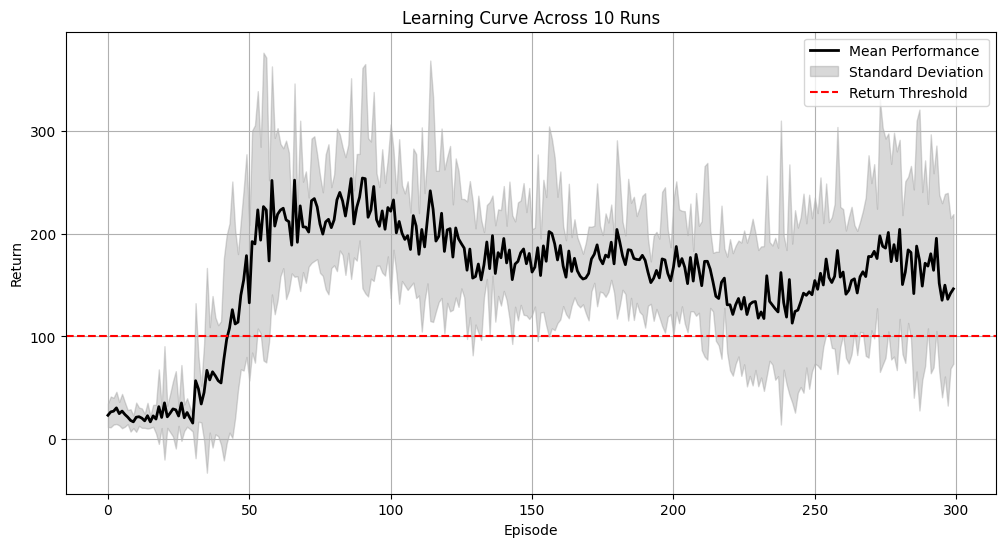

In [134]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it
 
results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

plt.figure(figsize=(12, 6))

# mean across runs
plt.plot(torch.arange(results.shape[1]), means, color='black', linewidth=2, label='Mean Performance')

#standard deviation
plt.fill_between(torch.arange(results.shape[1]), means - stds, means + stds, alpha=0.3, color='gray', label='Standard Deviation')

#threshold
plt.axhline(y=100, color='red', linestyle='--', label='Return Threshold')

plt.title('Learning Curve Across 10 Runs')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()

In [135]:
torch.save(policy_net.state_dict(), 'model.pth')

2.1
---

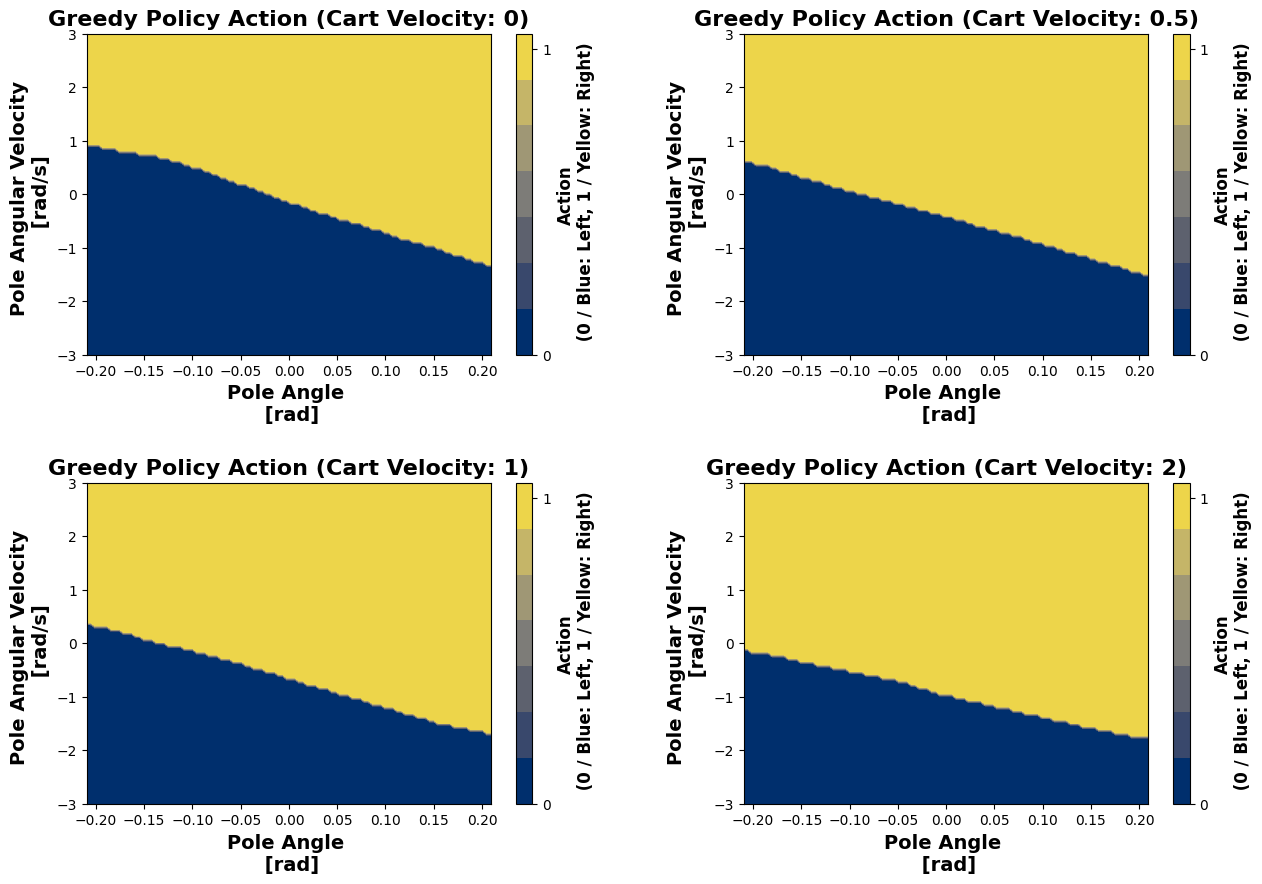

In [139]:
policy_net = DQN([4, 64, 64, 2]) 
policy_net.load_state_dict(torch.load('model.pth'))
policy_net.eval()  # Set the network to evaluation mode

angle_range = 0.2095
omega_range = 3
angle_samples = 100
omega_samples = 100
angles = torch.linspace(-angle_range, angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

# Define different cart velocities
cart_velocities = [0, 0.5, 1, 2]

plt.figure(figsize=(15, 10)) 

for index, cart_velocity in enumerate(cart_velocities):
    value_array = torch.zeros((angle_samples, omega_samples))

    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0., cart_velocity, angle, omega])
            with torch.no_grad():
                q_vals = policy_net(state)
                value = q_vals.argmax().item()
                value_array[i, j] = value

    ax = plt.subplot(2, 2, index + 1)  #for each cart velocity

    contour = plt.contourf(angles, omegas, value_array.T, cmap='cividis')
    #set the label to explain the color
    cbar = plt.colorbar(contour, ax=ax, ticks=[0, 1])
    cbar.set_label('Action\n (0 / Blue: Left, 1 / Yellow: Right)', fontsize=12,fontweight='bold')
    
    plt.title(f'Greedy Policy Action (Cart Velocity: {cart_velocity})', fontsize=16,fontweight='bold')
    plt.xlabel('Pole Angle \n [rad]', fontsize=14,fontweight='bold')
    plt.ylabel('Pole Angular Velocity \n [rad/s]', fontsize=14,fontweight='bold')
    plt.grid(False)
    
plt.subplots_adjust(wspace=0.3, hspace=0.4) 

plt.show()



2.2
---

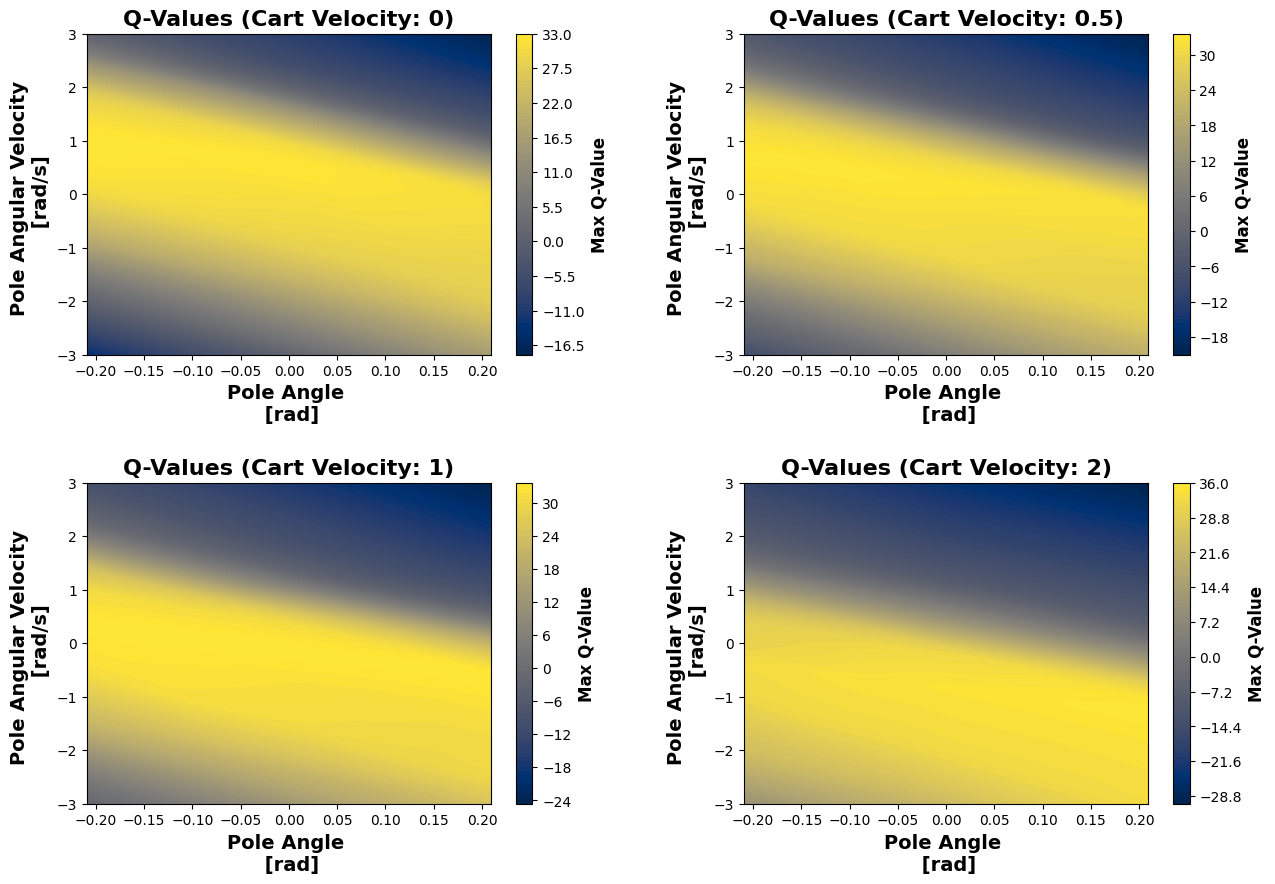

In [138]:
policy_net = DQN([4, 64, 64, 2]) 
policy_net.load_state_dict(torch.load('model.pth'))
policy_net.eval()  # Set the network to evaluation mode
angle_range = 0.2095
omega_range = 3
angle_samples = 100
omega_samples = 100
angles = torch.linspace(-angle_range, angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

# Define different cart velocities
cart_velocities = [0, 0.5, 1, 2]

plt.figure(figsize=(15, 10))

for index, cart_velocity in enumerate(cart_velocities):
    value_array = torch.zeros((angle_samples, omega_samples))

    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0., cart_velocity, angle, omega])
            with torch.no_grad():
                q_vals = policy_net(state)
                value = q_vals.max().item()
                value_array[i, j] = value

    ax = plt.subplot(2, 2, index + 1)  #  for each cart velocity

    contour = plt.contourf(angles, omegas, value_array.T, cmap='cividis', levels=100)
    #set label for q values
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label('Max Q-Value', fontsize=12,fontweight='bold')

    plt.title(f'Q-Values (Cart Velocity: {cart_velocity})', fontsize=16,fontweight='bold')
    plt.xlabel('Pole Angle \n [rad]', fontsize=14,fontweight='bold')
    plt.ylabel('Pole Angular Velocity \n [rad/s]', fontsize=14,fontweight='bold')
    plt.grid(False)

plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Adjust layout

plt.show()
